In [1]:
import pandas as pd
import yfinance as yf
import numpy as np
import datetime as dt
import copy
import matplotlib.pyplot as plt
from yahooquery import Ticker

In [2]:
def CAGR(DF):
    yd = DF.copy()   
    yd['cum_ret'] = (yd['Ret Total']).cumprod()
    n = len(yd)/(252)
    CAGR = (yd['cum_ret'].tolist()[-1]/1)**(1/n)-1
    return CAGR

In [3]:
def vol(DF):
    yd = DF.copy() 
    vol_a = yd['Ret Total'].std()*np.sqrt(252)
    return vol_a

In [4]:
def sharpe(DF,rf):
    yd = DF.copy() 
    sr = (CAGR(yd) - rf)/vol(yd)
    return sr

In [5]:
def max_dd(DF):
    yd = DF.copy() 
    yd['cum_ret'] = (yd['Ret Total']).cumprod()
    yd['cum_roll_max'] = yd['cum_ret'].cummax()
    yd['dd'] = yd['cum_roll_max'] - yd['cum_ret']
    yd['dd_pct'] = yd['dd']/yd['cum_roll_max']
    max_dd = yd['dd_pct'].max()
    return max_dd

In [6]:
#importando base
df_ibrx = pd.read_excel('C:/Users/hudsm/Documents/Quantitative Fund/Portfolio/Atividades/ETFs_Onshore.xlsx',sheet_name = 'IBRX100')
df_ibrx.head()

,Código,Ação,Tipo,Qtde. Teórica,Part. (%),Setor,Subsetor,Segmento
0,ABEV3,AMBEV S/A,ON,4.354.228.928,2936.0,Consumo não Cíclico,Bebidas,Cervejas e Refrigerantes
1,ALPA4,ALPARGATAS,PN N1,187.007.704,328.0,Consumo Cíclico,"Tecidos, Vestuário e Calçados",Calçados
2,ALSO3,ALIANSCSONAE,ON NM,127.374.163,186.0,Financeiro,Exploração de Imóveis,Exploração de Imóveis
3,AZUL4,AZUL,PN N2,317.471.474,363.0,Bens Industriais,Transporte,Transporte Aéreo
4,B3SA3,B3,ON NM,2.046.021.644,6301.0,Financeiro,Serviços Financeiros Diversos,Serviços Financeiros Diversos


In [7]:
# dando aquele tapa
df = df_ibrx
df = pd.DataFrame(df) 
df = df.dropna()
df['Part. (%)'] /= 100000
df.rename(columns={'Código\xa0':'Codigo'}, inplace = True)
df['Codigo'] = df['Codigo'] + ".SA"
tickers = df['Codigo']

In [8]:
yf_period = 1825

In [9]:
start = dt.date.today() + dt.timedelta(1) - dt.timedelta(yf_period)
end = dt.date.today() + dt.timedelta(1)
prices = {}
for t in tickers:
    try:
        prices[t] = yf.download(t,start,end,interval='1d')  
    except: 
        pass
    prices[t].dropna(how='all', inplace = True)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [10]:
prices2 = copy.deepcopy(prices)

In [11]:
for t in tickers:
    
    prices2[t]['Close_D-1'] = prices2[t]['Close'].shift(1)
    
    prices2[t]['roll_avg_5d'] = prices2[t]['Close'].rolling(5).mean()
    prices2[t]['roll_avg_10d'] = prices2[t]['Close'].rolling(10).mean()
    prices2[t]['roll_avg_20d'] = prices2[t]['Close'].rolling(20).mean()
    
    prices2[t]['roll_exp_5d'] = prices2[t]['Close'].ewm(span=5).mean()
    prices2[t]['roll_exp_10d'] = prices2[t]['Close'].ewm(span=10).mean()
    prices2[t]['roll_exp_20d'] = prices2[t]['Close'].ewm(span=20).mean()
    
    prices2[t]['roll_max_5d'] = prices2[t]['Close'].rolling(5).max()
    prices2[t]['roll_max_10d'] = prices2[t]['Close'].rolling(10).max()
    prices2[t]['roll_max_20d'] = prices2[t]['Close'].rolling(20).max()

    prices2[t]['roll_min_5d'] = prices2[t]['Close'].rolling(5).min()
    prices2[t]['roll_min_10d'] = prices2[t]['Close'].rolling(10).min()
    prices2[t]['roll_min_20d'] = prices2[t]['Close'].rolling(20).min()
    
    prices2[t].dropna(inplace=True)

In [34]:
prices2

{'ABEV3.SA':              Open       High        Low      Close  Adj Close    Volume  \
 Date                                                                      
 2015-09-30  19.60  19.750000  19.350000  19.420000  17.052202  12317500   
 2015-10-01  19.41  19.809999  19.350000  19.700001  17.298065  11101400   
 2015-10-02  19.59  20.120001  19.559999  20.059999  17.614170  10206500   
 2015-10-05  20.33  20.459999  20.190001  20.350000  17.868811   7815300   
 2015-10-06  20.40  20.440001  19.719999  19.889999  17.464895  11701900   
 ...           ...        ...        ...        ...        ...       ...   
 2020-08-24  13.06  13.110000  12.820000  12.860000  12.860000  18335400   
 2020-08-25  12.89  12.940000  12.700000  12.750000  12.750000  14960200   
 2020-08-26  12.74  12.940000  12.490000  12.700000  12.700000  29757700   
 2020-08-27  12.70  12.830000  12.600000  12.680000  12.680000  20747000   
 2020-08-28   0.00   0.000000   0.000000  12.750000  12.750000         0   


In [12]:
portfolio_ret = pd.DataFrame()
portfolio_ret['Date'] = np.array(prices2['ABEV3.SA'].index) #dict.keys()[0]
portfolio_ret = portfolio_ret.set_index('Date')
for t in tickers:
    portfolio_ret[str(t)] = 0
portfolio_ret['Ret Total'] = 0

In [13]:
portfolio_tickers = {} 

In [14]:
j = 0

for i in prices2['ABEV3.SA'].index:
    portfolio_tickers[i] = []

for i in prices2['ABEV3.SA'].index:

    print(i)
        
    prices3 = pd.DataFrame(columns=['Ticker','stochastic','R1', 'R2', 'R3', 'R4','Ranking_1','Ranking_2','Ranking_3','Ranking_4','Soma_total','Ranking_Final'])

    for t in tickers:

        try:
            

            prices3.loc[t,'Ticker'] = str(t)#.replace('.SA','')

            # stochastic
            prices3.loc[t,'stochastic'] = (prices2[t]['Close'].loc[i] - prices2[t]['roll_min_20d'].loc[i]) / (prices2[t]['roll_max_20d'].loc[i] - prices2[t]['roll_min_20d'].loc[i]) * 100

            #variacoes
            prices3.loc[t,'R1'] = prices2[t]['Close'].loc[i] / prices2[t]['Close_D-1'].loc[i] - 1
            prices3.loc[t,'R2'] = prices2[t]['Close'].loc[i] / prices2[t]['roll_exp_5d'].loc[i] - 1
            prices3.loc[t,'R3'] = prices2[t]['Close'].loc[i] / prices2[t]['roll_avg_20d'].loc[i] - 1
            prices3.loc[t,'R4'] = (prices2[t]['roll_max_20d'].loc[i] + prices2[t]['roll_min_20d'].loc[i]) / prices2[t]['Close'].loc[i] - 2

        except:
            continue

    #ranking
    prices3['Ranking_1'] = prices3['R1'].rank(ascending = True)
    prices3['Ranking_2'] = prices3['R2'].rank(ascending = False)
    prices3['Ranking_3'] = prices3['R3'].rank(ascending = True)
    prices3['Ranking_4'] = prices3['R4'].rank(ascending= False)
    prices3['Soma_total'] = prices3['Ranking_1'] + prices3['Ranking_2']*2 + prices3['Ranking_3']*2 + prices3['Ranking_4']
    prices3['Ranking_Final'] = prices3['Soma_total'].rank(ascending= True)

    #com stocastico
    prices_final = prices3[(prices3['R2']>0)&(prices3['R3']<0)&(prices3['stochastic']<30)].sort_values(['Ranking_Final'], ascending = True)
    
    #sem stocastico
    #prices_final = prices3[(prices3['R2']>0)&(prices3['R3']<0)].sort_values(['Ranking_Final'], ascending = True).head(15)

    tickers_premiados = prices_final['Ticker'].tolist()

    #decisão do portfolio para o dia seguinte  
    if (i+dt.timedelta(1)) in (prices2['ABEV3.SA'].index):
        portfolio_tickers[i+dt.timedelta(1)].append(tickers_premiados)
        
    elif (i+dt.timedelta(2)) in (prices2['ABEV3.SA'].index): 
        portfolio_tickers[i+dt.timedelta(2)].append(tickers_premiados)

    elif (i+dt.timedelta(3)) in (prices2['ABEV3.SA'].index): 
        portfolio_tickers[i+dt.timedelta(3)].append(tickers_premiados)
        
    print('portfolio_tickers ='+str(portfolio_tickers[i]))
    
    #backtesting

    if j>0:
        
        for t in portfolio_ret.columns.tolist():
            #try:
        
            if (i-dt.timedelta(1)) in (prices2['ABEV3.SA'].index):

                if t in str(portfolio_tickers[i-dt.timedelta(1)]) and t not in str(portfolio_tickers[i]): #tinha ontem e vendeu pela manhã
                    #print('tinha ontem e vendeu pela manhã: '+str(t))
                    portfolio_ret.loc[i,t] = (prices2[t]['Open'].loc[i] / prices2[t]['Close'].loc[i-dt.timedelta(1)])
                    continue

                elif t in str(portfolio_tickers[i-dt.timedelta(1)]) and t in str(portfolio_tickers[i]): #tinha ontem e não vendeu pela manhã
                    #print('tinha ontem e não vendeu pela manhã: '+str(t))
                    portfolio_ret.loc[i,t] = (prices2[t]['Close'].loc[i] / prices2[t]['Close'].loc[i-dt.timedelta(1)])
                    continue

                elif t not in str(portfolio_tickers[i-dt.timedelta(1)]) and t in str(portfolio_tickers[i]): #não tinha ontem e comprou pela manhã
                    #print('não tinha ontem e comprou pela manhã: '+str(t))
                    portfolio_ret.loc[i,t] = (prices2[t]['Close'].loc[i] / prices2[t]['Open'].loc[i])
                    continue
                    
            elif (i-dt.timedelta(2)) in (prices2['ABEV3.SA'].index):
                
                if t in str(portfolio_tickers[i-dt.timedelta(2)]) and t not in str(portfolio_tickers[i]): #tinha ontem e vendeu pela manhã
                    #print('tinha ontem e vendeu pela manhã: '+str(t))
                    portfolio_ret.loc[i,t] = (prices2[t]['Open'].loc[i] / prices2[t]['Close'].loc[i-dt.timedelta(2)])
                    continue

                elif t in str(portfolio_tickers[i-dt.timedelta(2)]) and t in str(portfolio_tickers[i]): #tinha ontem e não vendeu pela manhã
                    #print('tinha ontem e não vendeu pela manhã: '+str(t))
                    portfolio_ret.loc[i,t] = (prices2[t]['Close'].loc[i] / prices2[t]['Close'].loc[i-dt.timedelta(2)])
                    continue

                elif t not in str(portfolio_tickers[i-dt.timedelta(2)]) and t in str(portfolio_tickers[i]): #não tinha ontem e comprou pela manhã
                    #print('não tinha ontem e comprou pela manhã: '+str(t))
                    portfolio_ret.loc[i,t] = (prices2[t]['Close'].loc[i] / prices2[t]['Open'].loc[i])
                    continue
        
            elif (i-dt.timedelta(3)) in (prices2['ABEV3.SA'].index):
                
                if t in str(portfolio_tickers[i-dt.timedelta(3)]) and t not in str(portfolio_tickers[i]): #tinha ontem e vendeu pela manhã
                    #print('tinha ontem e vendeu pela manhã: '+str(t))
                    portfolio_ret.loc[i,t] = (prices2[t]['Open'].loc[i] / prices2[t]['Close'].loc[i-dt.timedelta(3)])
                    continue

                elif t in str(portfolio_tickers[i-dt.timedelta(3)]) and t in str(portfolio_tickers[i]): #tinha ontem e não vendeu pela manhã
                    #print('tinha ontem e não vendeu pela manhã: '+str(t))
                    portfolio_ret.loc[i,t] = (prices2[t]['Close'].loc[i] / prices2[t]['Close'].loc[i-dt.timedelta(3)])
                    continue

                elif t not in str(portfolio_tickers[i-dt.timedelta(3)]) and t in str(portfolio_tickers[i]): #não tinha ontem e comprou pela manhã
                    #print('não tinha ontem e comprou pela manhã: '+str(t))
                    portfolio_ret.loc[i,t] = (prices2[t]['Close'].loc[i] / prices2[t]['Open'].loc[i])
                    continue
                    
            #except IndexError:
             #   print('IndexError dentro do loop em: '+str(i)+', no ticker: '+str(t))
              #  continue

            #except:
             #   print('Except dentro do loop em: '+str(i)+', no ticker: '+str(t))
              #  continue

        portfolio_ret.loc[i,'Ret Total'] = portfolio_ret.loc[i,:][portfolio_ret.loc[i,:] != 0].mean()

    j = j + 1
    
    #except IndexError:
     #   print('IndexError em: '+str(i))
      #  j = j + 1
       # continue
        
    #except:
     #   print('Except em: '+str(i))
      #  j = j + 1
       # continue

2015-09-30 00:00:00


C:\Users\hudsm\anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in double_scalars


portfolio_tickers =[]
2015-10-01 00:00:00
portfolio_tickers =[['ALPA4.SA', 'GOLL4.SA', 'COGN3.SA', 'BBAS3.SA', 'ALSO3.SA', 'BBSE3.SA', 'ITSA4.SA', 'ITUB4.SA', 'CESP6.SA', 'RADL3.SA']]
2015-10-02 00:00:00
portfolio_tickers =[['PETR4.SA', 'PETR3.SA', 'VVAR3.SA', 'SMLS3.SA', 'BBSE3.SA', 'COGN3.SA', 'CMIG4.SA', 'ALSO3.SA', 'ITSA4.SA', 'BBDC4.SA', 'SANB11.SA', 'BBDC3.SA', 'MYPK3.SA', 'VIVT4.SA', 'VALE3.SA']]
2015-10-05 00:00:00
portfolio_tickers =[['SMLS3.SA', 'RAIL3.SA', 'BRAP4.SA', 'PRIO3.SA', 'BRSR6.SA', 'GOLL4.SA', 'ALPA4.SA', 'QUAL3.SA', 'BRML3.SA', 'TIMP3.SA', 'BPAN4.SA', 'BTOW3.SA']]
2015-10-06 00:00:00
portfolio_tickers =[['CSNA3.SA', 'RAIL3.SA', 'SMLS3.SA', 'VVAR3.SA', 'BRAP4.SA', 'GOLL4.SA', 'BRSR6.SA', 'BRML3.SA', 'TIMP3.SA', 'MGLU3.SA', 'USIM5.SA', 'BPAN4.SA']]
2015-10-07 00:00:00
portfolio_tickers =[['VVAR3.SA', 'MGLU3.SA', 'RAIL3.SA', 'USIM5.SA', 'BRML3.SA', 'TIMP3.SA', 'CVCB3.SA']]
2015-10-08 00:00:00
portfolio_tickers =[['USIM5.SA', 'BRSR6.SA', 'CVCB3.SA', 'TIMP3.SA', 'CESP6

C:\Users\hudsm\anaconda3\lib\site-packages\ipykernel_launcher.py:80: RuntimeWarning: divide by zero encountered in double_scalars


In [91]:
portfolio_ret[portfolio_ret != 0]

,ABEV3.SA,ALPA4.SA,ALSO3.SA,AZUL4.SA,B3SA3.SA,BBAS3.SA,BBDC3.SA,BBDC4.SA,BBSE3.SA,BEEF3.SA,...,TRPL4.SA,UGPA3.SA,USIM5.SA,VALE3.SA,VIVT4.SA,VVAR3.SA,WEGE3.SA,YDUQ3.SA,Ret Total,Ret Acumulado
Date,,,,,,,,,,,,,,,,,,,,,
2015-10-01,NaN,1.009160,1.014483,NaN,NaN,0.980921,NaN,NaN,0.999601,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.991357,0.991357
2015-10-02,NaN,1.000000,0.977566,NaN,NaN,0.995305,1.049959,1.045518,1.064246,NaN,...,NaN,NaN,NaN,1.043326,1.036536,0.854167,NaN,NaN,1.024132,1.015280
2015-10-05,NaN,1.080764,1.013908,NaN,NaN,NaN,1.017991,1.021323,1.010499,NaN,...,NaN,NaN,NaN,1.015713,1.017755,0.943089,NaN,NaN,1.006262,1.021638
2015-10-06,NaN,1.017663,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.006061,NaN,NaN,0.996622,NaN,NaN,1.011195,1.033075
2015-10-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.021084,NaN,NaN,1.179661,NaN,NaN,1.041221,1.075659
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.002956,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.003327,2.790699
2020-08-24,NaN,NaN,NaN,NaN,NaN,1.017026,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.009446,2.817060
2020-08-25,NaN,NaN,NaN,NaN,NaN,1.009865,0.990399,0.991569,NaN,NaN,...,NaN,NaN,NaN,NaN,0.995399,NaN,NaN,NaN,0.997602,2.810306


In [72]:
i = dt.datetime.today()-dt.timedelta(4)

In [79]:
prices2['ABEV3.SA'].index.tolist()

[Timestamp('2015-09-30 00:00:00'),
 Timestamp('2015-10-01 00:00:00'),
 Timestamp('2015-10-02 00:00:00'),
 Timestamp('2015-10-05 00:00:00'),
 Timestamp('2015-10-06 00:00:00'),
 Timestamp('2015-10-07 00:00:00'),
 Timestamp('2015-10-08 00:00:00'),
 Timestamp('2015-10-09 00:00:00'),
 Timestamp('2015-10-13 00:00:00'),
 Timestamp('2015-10-14 00:00:00'),
 Timestamp('2015-10-15 00:00:00'),
 Timestamp('2015-10-16 00:00:00'),
 Timestamp('2015-10-19 00:00:00'),
 Timestamp('2015-10-20 00:00:00'),
 Timestamp('2015-10-21 00:00:00'),
 Timestamp('2015-10-22 00:00:00'),
 Timestamp('2015-10-23 00:00:00'),
 Timestamp('2015-10-26 00:00:00'),
 Timestamp('2015-10-27 00:00:00'),
 Timestamp('2015-10-28 00:00:00'),
 Timestamp('2015-10-29 00:00:00'),
 Timestamp('2015-10-30 00:00:00'),
 Timestamp('2015-11-03 00:00:00'),
 Timestamp('2015-11-04 00:00:00'),
 Timestamp('2015-11-05 00:00:00'),
 Timestamp('2015-11-06 00:00:00'),
 Timestamp('2015-11-09 00:00:00'),
 Timestamp('2015-11-10 00:00:00'),
 Timestamp('2015-11-

In [88]:
i = prices2['ABEV3.SA'].index[4]

In [89]:
prices2['ABEV3.SA'].index.tolist()[prices2['ABEV3.SA'].index.tolist().index(i)]

Timestamp('2015-10-06 00:00:00')

In [ ]:
portfolio_tickers[i+dt.timedelta(1)].append(tickers_premiados)

In [15]:
portfolio_ret

,ABEV3.SA,ALPA4.SA,ALSO3.SA,AZUL4.SA,B3SA3.SA,BBAS3.SA,BBDC3.SA,BBDC4.SA,BBSE3.SA,BEEF3.SA,...,TOTS3.SA,TRPL4.SA,UGPA3.SA,USIM5.SA,VALE3.SA,VIVT4.SA,VVAR3.SA,WEGE3.SA,YDUQ3.SA,Ret Total
Date,,,,,,,,,,,,,,,,,,,,,
2015-09-30,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
2015-10-01,0.0,1.009160,1.014483,0.0,0.0,0.980921,0.000000,0.000000,0.999601,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.991357
2015-10-02,0.0,1.000000,0.977566,0.0,0.0,0.995305,1.049959,1.045518,1.064246,0.0,...,0.0,0.0,0.0,0.000000,1.043326,1.036536,0.854167,0.0,0.0,1.024132
2015-10-05,0.0,1.080764,1.013908,0.0,0.0,0.000000,1.017991,1.021323,1.010499,0.0,...,0.0,0.0,0.0,0.000000,1.015713,1.017755,0.943089,0.0,0.0,1.006262
2015-10-06,0.0,1.017663,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,1.006061,0.000000,0.000000,0.996622,0.0,0.0,1.011195
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-24,0.0,0.000000,0.000000,0.0,0.0,1.017026,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.009446
2020-08-25,0.0,0.000000,0.000000,0.0,0.0,1.009865,0.990399,0.991569,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.995399,0.000000,0.0,0.0,0.997602
2020-08-26,0.0,0.000000,0.000000,0.0,0.0,0.979179,0.977551,0.979216,0.984299,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.993368,0.000000,0.0,0.0,0.990299


In [16]:
portfolio_ret.drop(portfolio_ret.index[0],inplace=True)
portfolio_ret.drop(portfolio_ret.index[-1],inplace=True)

In [17]:
len(portfolio_ret)

1219

In [18]:
#portfolio_ret[(portfolio_ret.T != 0).any()]

In [19]:
#portfolio_ret.iloc[269,portfolio_ret.columns.get_loc('NEOE3.SA')]

In [20]:
#portfolio_ret.iloc[270,:][portfolio_ret.iloc[270,:] != 0]

In [21]:
#portfolio_ret['Ret Total'][270:300]

In [22]:
#portfolio_ret['Ret Total'].cumprod().tail(50)

In [23]:
start_BOVA11 = prices2['BBAS3.SA'].index[0]
price_BOVA11 = {}

In [24]:
try:
    price_BOVA11 = yf.download('BOVA11.SA',start_BOVA11,end,interval='1d')  
except: 
    print('Erro no BOVA11')
    pass
price_BOVA11.dropna(how='all', inplace = True)

[*********************100%***********************]  1 of 1 completed


In [25]:
price_BOVA11['Ret'] = price_BOVA11['Adj Close'].pct_change()

In [26]:
price_BOVA11.drop(price_BOVA11.index[0], inplace=True)

In [27]:
BOVA11_ret_acum = (1+price_BOVA11['Ret']).cumprod()

In [28]:
portfolio_ret['Ret Acumulado'] = (portfolio_ret['Ret Total']).cumprod()

In [29]:
portfolio_ret_acum = portfolio_ret['Ret Acumulado']

In [30]:
portfolio_CAGR = CAGR(portfolio_ret)
print('portfolio_CAGR = '+str(portfolio_CAGR))
portfolio_sharpe = sharpe(portfolio_ret,0.025)
print('portfolio_sharpe = '+str(portfolio_sharpe))
portfolio_max_dd = max_dd(portfolio_ret)
print('portfolio_max_dd = '+str(portfolio_max_dd))

portfolio_CAGR = 0.23632217721404158
portfolio_sharpe = 0.893439350854428
portfolio_max_dd = 0.3492195806111278


In [62]:
start2 = '2020-03-02'
end2 = dt.datetime.today()

In [63]:
portfolio_ret_acum2 = (portfolio_ret['Ret Total'].loc[start2:end2]).cumprod()

In [64]:
BOVA11_ret_acum2 = ((price_BOVA11['Ret']+1).loc[start2:end2]).cumprod()

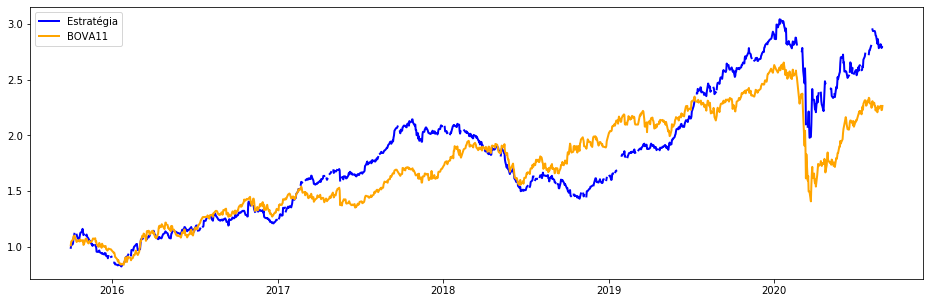

In [66]:
plt.figure(figsize=(16,5))
plt.plot(portfolio_ret_acum, marker='', color='blue', linewidth=2, label="Estratégia")
plt.plot(BOVA11_ret_acum, marker='', color='orange', linewidth=2, label="BOVA11")
plt.legend()

In [32]:
hoje = dt.datetime.today().strftime('%Y-%m-%d')

In [33]:
portfolio_ret.to_excel('C:/Users/hudsm/Documents/Quantitative Fund/Portfolio/Atividades/{}_IBRX_Result_Medias_vf2.xlsx'.format(hoje),sheet_name = 'IBRX100')